In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# ZFNet

Source: https://towardsdatascience.com/zfnet-an-explanation-of-paper-with-code-f1bd6752121d

In [2]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

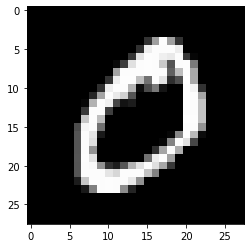

In [3]:
plt.imshow(training_images[1],cmap='gray')

## Train the model

In [4]:
training_images = training_images[:1000]
training_labels = training_labels[:1000]
test_images = test_images[:100]
test_labels = test_labels[:100]

training_images = tf.map_fn(lambda i: tf.stack([i]*3, axis=-1), training_images).numpy()
test_images = tf.map_fn(lambda i: tf.stack([i]*3, axis=-1), test_images).numpy()

training_images = tf.image.resize(training_images, [224, 224]).numpy()
test_images = tf.image.resize(test_images, [224, 224]).numpy()

training_images = training_images.reshape(1000, 224, 224, 3)
training_images = training_images / 255.0
test_images = test_images.reshape(100, 224, 224, 3)
test_images = test_images / 255.0

training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

num_len_train = int(0.8 * len(training_images))

ttraining_images = training_images[:num_len_train]
ttraining_labels = training_labels[:num_len_train]

valid_images = training_images[num_len_train:]
valid_labels = training_labels[num_len_train:]

training_images = ttraining_images
training_labels = ttraining_labels

model = tf.keras.models.Sequential([
                                    
		tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',
			input_shape=(224, 224, 3)),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),

		tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Flatten(),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(10, activation='softmax')
	])


model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), \
              loss='categorical_crossentropy', \
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(5)])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', \
                                            		factor=0.1, patience=1, \
																								min_lr=0.00001)

model.fit(training_images, training_labels, batch_size=128, \
          validation_data=(valid_images, valid_labels), \
					epochs=90, callbacks=[reduce_lr])


2022-05-17 10:44:45.307511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 10:44:45.336179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 10:44:45.336351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 10:44:45.336827: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/90


2022-05-17 10:44:48.298951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-17 10:44:48.695577: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7/7 [==============================] - 5s 325ms/step - loss: 2.6118 - accuracy: 0.1612 - top_k_categorical_accuracy: 0.5763 - val_loss: 2.1427 - val_accuracy: 0.2200 - val_top_k_categorical_accuracy: 0.7400 - lr: 0.0100
Epoch 2/90
7/7 [==============================] - 1s 160ms/step - loss: 2.0019 - accuracy: 0.3275 - top_k_categorical_accuracy: 0.7575 - val_loss: 2.3730 - val_accuracy: 0.2550 - val_top_k_categorical_accuracy: 0.8050 - lr: 0.0100
Epoch 3/90
7/7 [==============================] - 1s 162ms/step - loss: 2.2416 - accuracy: 0.3388 - top_k_categorical_accuracy: 0.8000 - val_loss: 1.7700 - val_accuracy: 0.3650 - val_top_k_categorical_accuracy: 0.8700 - lr: 1.0000e-03
Epoch 4/90
7/7 [==============================] - 1s 161ms/step - loss: 1.3360 - accuracy: 0.5800 - top_k_categorical_accuracy: 0.9150 - val_loss: 1.3943 - val_accuracy: 0.5500 - val_top_k_categorical_accuracy: 0.9050 - lr: 1.0000e-03
Epoch 5/90
7/7 [==============================] - 1s 160ms/step - loss: 1.0193 

## Evaluate the trained model

In [5]:
model.evaluate(test_images,test_labels)

4/4 [==============================] - 0s 44ms/step - loss: 0.4257 - accuracy: 0.8800 - top_k_categorical_accuracy: 0.9900


[0.42566344141960144, 0.8799999952316284, 0.9900000095367432]

In [6]:
from sklearn.metrics import classification_report

In [7]:
predictions = (model.predict(test_images) > 0.5).astype("int32")

In [8]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        14
           2       0.75      0.75      0.75         8
           3       1.00      0.82      0.90        11
           4       0.80      0.86      0.83        14
           5       1.00      0.86      0.92         7
           6       1.00      0.60      0.75        10
           7       0.92      0.80      0.86        15
           8       0.50      1.00      0.67         2
           9       0.90      0.82      0.86        11

   micro avg       0.90      0.84      0.87       100
   macro avg       0.89      0.85      0.85       100
weighted avg       0.92      0.84      0.87       100
 samples avg       0.84      0.84      0.84       100



/home/luke/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Free up the GPU's memory

In [9]:
from numba import cuda
cuda.select_device(0)
cuda.close()